In [1]:
# importing required packages
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load('en')

from spacy import displacy
#from spacy.lang.en import English
#parser = English()

#from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin 

#from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, cohen_kappa_score

from scipy.sparse import csr_matrix

np.random.seed(42)
%matplotlib inline

In [2]:
# set up display area to show dataframe in jupyter qtconsole

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', 1000)

pd.set_option('display.max_colwidth', -1)

In [25]:
myDir = Path.cwd().parents[0]
dataFolder = myDir / 'data/asap-sas'
ratingsFolder = myDir / 'data/ratings'

print(dataFolder)

gradeMap = {1: 10,
                2: 10,
                3: 10,
                4:10,
                5: 10,
                6: 10,
                7:10,
                8:10,
                9:10,
                10:8}

subjectMap = {1: 'Science',
            2: 'Science',
            3: 'English Language Arts',
            4: 'English Language Arts',
            5: 'Biology',
            6: 'Biology',
            7:'English',
            8:'English',
            9:'English',
            10:'Science'}

scoreMap = {0: 0,
            1: 1,
            2: 2,
            3: 2}

df = pd.read_csv(dataFolder/'train.tsv', sep='\t', header=0)  #read data into dataframe
df.drop('Score2', inplace=True, axis=1) #Score 2 is for inter-rate reliability only

df['subject'] = df['EssaySet'].map(subjectMap)
df['studentGrade'] = df['EssaySet'].map(gradeMap)
df['styleScore'] = df['Score1'].map(scoreMap)

df = df[['Id','EssaySet','subject','studentGrade','EssayText','Score1','styleScore']] #rearrange columns

df.head()

C:\Users\Devanshi\Desktop\finalProject\data\asap-sas


,Id,EssaySet,subject,studentGrade,EssayText,Score1,styleScore
0,1,1,Science,10,"Some additional information that we would need to replicate the experiment is how much vinegar should be placed in each identical container, how or what tool to use to measure the mass of the four different samples and how much distilled water to use to rinse the four samples after taking them out of the vinegar.",1,1
1,2,1,Science,10,"After reading the expirement, I realized that the additional information you need to replicate the expireiment is one, the amant of vinegar you poured in each container, two, label the containers before you start yar expirement and three, write a conclusion to make sure yar results are accurate.",1,1
2,3,1,Science,10,"What you need is more trials, a control set up, and an exact amount of vinegar to pour in each cup/beaker. You could also take and check the mass every 30 min or 1 hour.",1,1
3,4,1,Science,10,The student should list what rock is better and what rock is the worse in the procedure.,0,0
4,5,1,Science,10,"For the students to be able to make a replicate, they would need to tell use how much vinegar is used and what tipe of materials is needed for the expirement.",2,2


In [26]:
# Take only essay set 1
set_1 = df[(df['EssaySet'] == 1)].copy()
set_1.shape

(1672, 7)

In [ ]:
# Randomly reorder the data to make it qualitative
sns.barplot(x=x, y=y3, palette="deep")
ax3.set_ylabel("Qualitative")


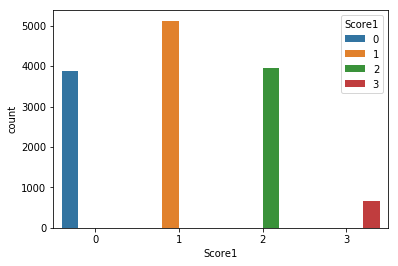

In [27]:
sns.countplot(x="Score1", data=df[~(df.subject == "Biology")], orient='v', hue="Score1")

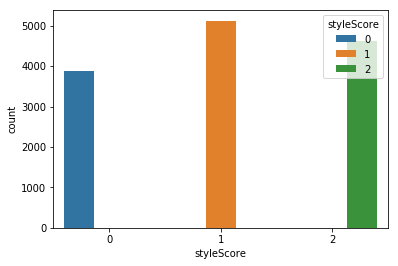

In [28]:
sns.countplot(x="styleScore", data=df[~(df.subject == "Biology")], orient='v', hue="styleScore")

In [ ]:
del df

df = df[~(df.subject == "Biology")] #Remove Biology

In [29]:
X = set_1[['EssayText','styleScore']]
y = X.pop('styleScore')


train, test, y_train_tmp, y_test_tmp = train_test_split(X, y, test_size=0.30, random_state=42)

#Adding the is_copy to False otherwise we get SettingWithCopyWarning
train = train.copy()
test = test.copy()

train.head()

,EssayText
1145,"You would need to know how much vinegar was put in to each sample, find the size and shape of the container so the same amount of vinegar was actually covering the sample. You would need to know the shape or volume of sample because the surface are has to be the same so the same amount is affected by the vinegar."
842,"In order to replicate experiment I would need to know exactly how much vinegar to pour in each container, how much of each sample to put in the container, and"
1554,The additional information you would need in order to replicate the experiment form a hypothesis. Draw a conclusion. Say what you are experimenting.
1526,To replicate this experiment you would need to state you problem. What is the person for this lab also you need to indicate your independent and dependent variables.
497,1) I would need to know how much vinegar is being put into the sample. ^p 2) What are they trying to find out through pass is to amount. ^p 3) Was there a control group in this experiment.


In [7]:
# new_df = train[['EssayText']][0:5]
# new_df = new_df.copy() 

# new_df.head()

## Feature Extraction

In [30]:
def get_custom_features(col):

    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    tokens = []
    word_count = []
    avg_word_len = []


    aoa_ratings_df = pd.read_csv(ratingsFolder/'AoA_Ratings.csv')
    aoa_ratings = dict(zip(aoa_ratings_df.Word, aoa_ratings_df.AoA))
    maturity_tokens = []
    maturity = []

    conc_ratings_df = pd.read_csv(ratingsFolder/'Concreteness_Ratings.csv')
    conc_ratings = dict(zip(conc_ratings_df.Word, conc_ratings_df.Concreteness))
    concreteness = []
    conc_tokens = []    


    for doc in nlp.pipe(col, batch_size=50, n_threads=4):

        if doc.is_parsed:



            #Add placeholders for CONTENT words, else parse as usual
            tokens.append(['__{}__'.format(w.pos_) if w.pos_ in content_words else w.lemma_.lower() for w in doc])

            #Count words which are not punctuation
            tmp_word_count = []
            word_count.append(len([w for w in doc if not w.is_punct]))
            tmp_word_count.append([len(w.shape_) for w in doc if not w.is_punct])

            for i in tmp_word_count:
                avg_word_len.append(sum(i)/len(i))


            #-------------------Maturity
            mat_tmp = []
            maturity_tokens.append([w.text.lower() if w.lemma_ == '-PRON-' else w.lemma_.lower() for w in doc])

            #maturity.append([value.get('name') for value in d.values()])
            mat_tmp.append([aoa_ratings[t] for a in maturity_tokens for t in a if t in aoa_ratings])

             #Now get avg maturity per doc
            for j in mat_tmp:
                maturity.append(sum(j)/len(j))

            #----------Concreteness
            conc_tmp = []
            conc_tokens.append([w.text.lower() for w in doc])
            conc_tmp.append([conc_ratings[t] for a in conc_tokens for t in a if t in conc_ratings])

            #Now get avg concreteness per doc
            for k in conc_tmp:
                concreteness.append(sum(k)/len(k))

        else:
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails

            tokens.append(None)
            word_count.append(None)
            avg_word_len.append(None)
            maturity.append(None)
            concreteness.append(None)

    return word_count, avg_word_len, maturity, concreteness  

def spacy_tokenizer(doc):
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    doc = nlp(doc)
    
    #remove ^p (bullet points)
    
    return ['__{}__'.format(w.pos_) if w.pos_ in content_words else w.lemma_.lower() for w in doc]  
    
def spacy_pos_tagger(doc):
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    doc = nlp(doc)
    
    #remove ^p (bullet points)
    
    return ['__{}__'.format(w.pos_) if w.pos_ in content_words else w.pos_ for w in doc]  
    

### Get Features
* custom features

In [34]:
#Get handcrafted features
word_count, avg_word_len, maturity, concreteness = get_custom_features(train['EssayText'])

custom_features_df = pd.DataFrame(index=train.index)

custom_features_df['total_words'] = word_count
custom_features_df['avg_word_length'] = avg_word_len
custom_features_df['maturity'] = maturity
custom_features_df['concreteness'] = concreteness

scaled_features = StandardScaler().fit_transform(
                                   custom_features_df.astype(float))

custom_features_df = pd.DataFrame(scaled_features, index=train.index, 
                               columns=['total_words','avg_word_length','maturity','concreteness'])

custom_features_df.head()


,total_words,avg_word_length,maturity,concreteness
1145,0.665272,-0.447669,-9.091595,-9.168278
842,-0.781089,-0.797001,-6.467719,-1.379700
1554,-1.097481,-0.169216,1.888996,1.985227
1526,-0.871487,0.793014,8.284416,5.641698
497,-0.374300,-1.691729,4.238500,2.039050


* N-grams (words)

In [32]:
#Get text BoW n-grams

#Initialise vectoriser
count_vectorizer = CountVectorizer(tokenizer=spacy_tokenizer,  ngram_range=(1,3), max_features=10000)
text_ngrams = count_vectorizer.fit_transform(train['EssayText'])

print(text_ngrams.shape)
#print(count_vect.vocabulary_)

scaled_text_ngrams = StandardScaler(with_mean=False).fit_transform(text_ngrams.astype(float))
text_ngrams_df = pd.DataFrame(scaled_text_ngrams.toarray(), columns=count_vectorizer.get_feature_names(), index=train.index)
text_ngrams_df.head()
#DataFrame.values

(1170, 8322)


,,,-how,-how __ADJ__,-what,-what __NOUN__,-pron-,-pron- __ADV__,-pron- __VERB__,1,1 .,2,2 ),2 .,3,3 .,4,4 .,4 __NOUN__,5,5 .,__ADJ__,__ADJ__ :,__ADJ__ __ADJ__,__ADJ__ __NOUN__,...,without __VERB__ any,without __VERB__ that,without __VERB__ the,without a,without a __NOUN__,without that,without that __NOUN__,without that i,without the,without the __ADJ__,without the __NOUN__,without these,without these -pron-,without these __NOUN__,without these __VERB__,without these three,without this,without this __NOUN__,without this the,wt,wt __ADV__,wt __ADV__ of,zero,zero as,zero as the
1145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
from yellowbrick.text import FreqDistVisualizer

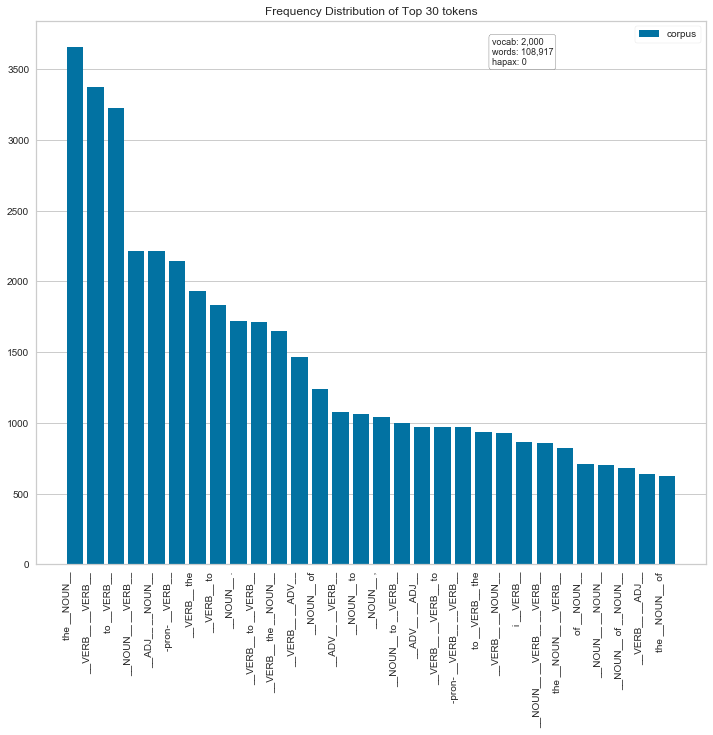

In [12]:
plt.figure(figsize=(12,10))
visualizer = FreqDistVisualizer(features=count_vectorizer.get_feature_names(), orient='v',n=30 )
visualizer.fit(text_ngrams)
visualizer.poof()

* n-grams (POS)

In [33]:
#Get POS n-grams

pos_vectorizer = CountVectorizer(ngram_range=(1,3), max_features=10000, tokenizer=spacy_pos_tagger)
pos_ngrams = pos_vectorizer.fit_transform(train['EssayText'])
print(pos_ngrams.shape)


scaled_pos_ngrams = StandardScaler(with_mean=False).fit_transform(pos_ngrams.astype(float))

pos_ngrams_df = pd.DataFrame(scaled_pos_ngrams.toarray(), 
                             columns=pos_vectorizer.get_feature_names(), 
                             index=train.index)

pos_ngrams_df.head()



(1170, 1456)


,ADP,ADP ADP,ADP ADP CCONJ,ADP ADP DET,ADP ADP NUM,ADP ADP PRON,ADP ADP PUNCT,ADP ADP __ADJ__,ADP ADP __ADV__,ADP ADP __NOUN__,ADP ADP __VERB__,ADP CCONJ,ADP CCONJ ADP,ADP CCONJ DET,ADP CCONJ PART,ADP CCONJ __ADJ__,ADP CCONJ __ADV__,ADP CCONJ __NOUN__,ADP CCONJ __VERB__,ADP DET,ADP DET ADP,ADP DET CCONJ,ADP DET DET,ADP DET NUM,ADP DET PART,...,__VERB__ __NOUN__ DET,__VERB__ __NOUN__ NUM,__VERB__ __NOUN__ PART,__VERB__ __NOUN__ PRON,__VERB__ __NOUN__ PUNCT,__VERB__ __NOUN__ SPACE,__VERB__ __NOUN__ X,__VERB__ __NOUN__ __ADJ__,__VERB__ __NOUN__ __ADV__,__VERB__ __NOUN__ __NOUN__,__VERB__ __NOUN__ __PROPN__,__VERB__ __NOUN__ __VERB__,__VERB__ __VERB__,__VERB__ __VERB__ ADP,__VERB__ __VERB__ CCONJ,__VERB__ __VERB__ DET,__VERB__ __VERB__ NUM,__VERB__ __VERB__ PART,__VERB__ __VERB__ PRON,__VERB__ __VERB__ PUNCT,__VERB__ __VERB__ SPACE,__VERB__ __VERB__ __ADJ__,__VERB__ __VERB__ __ADV__,__VERB__ __VERB__ __NOUN__,__VERB__ __VERB__ __VERB__
1145,2.310997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.020581,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.142360,1.339455,0.0,0.0,0.0,4.103304,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000
842,1.320570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.812348,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.724622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428472,0.000000,0.0,0.0,0.0,1.025826,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000
1554,0.330142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.724622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.856944,1.339455,0.0,0.0,0.0,0.000000,0.0,1.952942,0.0,0.0,0.0,0.0,0.00000
1526,0.330142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.604116,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428472,0.000000,0.0,0.0,0.0,1.025826,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000
497,0.990427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.208232,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.285416,1.339455,0.0,0.0,0.0,1.025826,0.0,0.000000,0.0,0.0,0.0,0.0,1.17363


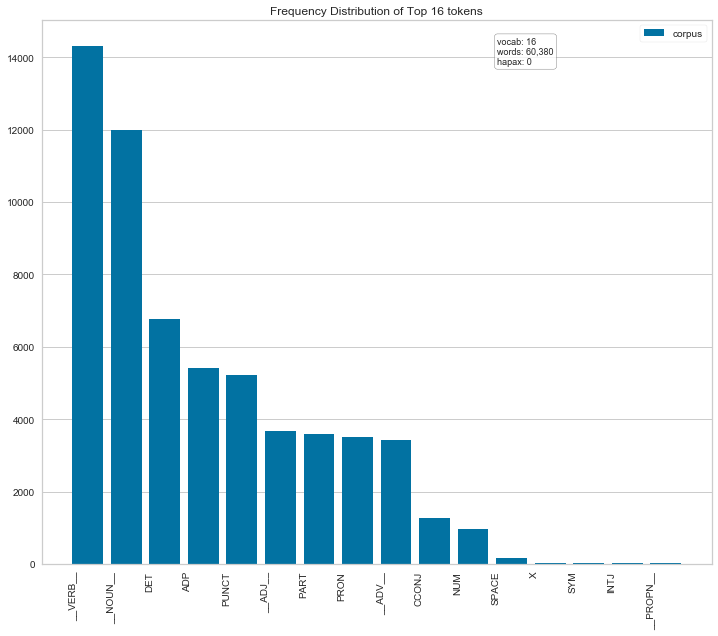

In [15]:
plt.figure(figsize=(12,10))
visualizer = FreqDistVisualizer(features=pos_vectorizer.get_feature_names(), orient='v', n=16)
visualizer.fit(pos_ngrams)
visualizer.poof()

In [35]:
# Concatenate all the features
merged_1 = pd.merge(custom_features_df, pos_ngrams_df, how='inner',left_index=True, right_index=True, copy=True)
merged_2 = pd.merge(merged_1, text_ngrams_df, how='inner',left_index=True, right_index=True, copy=True)

print(merged_2.shape)
merged_2.head()

(1170, 9782)


,total_words,avg_word_length,maturity,concreteness,ADP,ADP ADP,ADP ADP CCONJ,ADP ADP DET,ADP ADP NUM,ADP ADP PRON,ADP ADP PUNCT,ADP ADP __ADJ__,ADP ADP __ADV__,ADP ADP __NOUN__,ADP ADP __VERB__,ADP CCONJ,ADP CCONJ ADP,ADP CCONJ DET,ADP CCONJ PART,ADP CCONJ __ADJ__,ADP CCONJ __ADV__,ADP CCONJ __NOUN__,ADP CCONJ __VERB__,ADP DET,ADP DET ADP,...,without __VERB__ any,without __VERB__ that,without __VERB__ the,without a,without a __NOUN__,without that,without that __NOUN__,without that i,without the,without the __ADJ__,without the __NOUN__,without these,without these -pron-,without these __NOUN__,without these __VERB__,without these three,without this,without this __NOUN__,without this the,wt,wt __ADV__,wt __ADV__ of,zero,zero as,zero as the
1145,0.665272,-0.447669,-9.091595,-9.168278,2.310997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.020581,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842,-0.781089,-0.797001,-6.467719,-1.379700,1.320570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.812348,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1554,-1.097481,-0.169216,1.888996,1.985227,0.330142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1526,-0.871487,0.793014,8.284416,5.641698,0.330142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.604116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,-0.374300,-1.691729,4.238500,2.039050,0.990427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.208232,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Prepare X & Y data

In [37]:
feature_names = merged_2.columns

In [41]:
X_train = pd.SparseDataFrame(data=merged_2, columns=feature_names)
X_train.head()

#X_train = csr_matrix(merged_2) 
# X_train

,total_words,avg_word_length,maturity,concreteness,ADP,ADP ADP,ADP ADP CCONJ,ADP ADP DET,ADP ADP NUM,ADP ADP PRON,ADP ADP PUNCT,ADP ADP __ADJ__,ADP ADP __ADV__,ADP ADP __NOUN__,ADP ADP __VERB__,ADP CCONJ,ADP CCONJ ADP,ADP CCONJ DET,ADP CCONJ PART,ADP CCONJ __ADJ__,ADP CCONJ __ADV__,ADP CCONJ __NOUN__,ADP CCONJ __VERB__,ADP DET,ADP DET ADP,...,without __VERB__ any,without __VERB__ that,without __VERB__ the,without a,without a __NOUN__,without that,without that __NOUN__,without that i,without the,without the __ADJ__,without the __NOUN__,without these,without these -pron-,without these __NOUN__,without these __VERB__,without these three,without this,without this __NOUN__,without this the,wt,wt __ADV__,wt __ADV__ of,zero,zero as,zero as the
1145,0.665272,-0.447669,-9.091595,-9.168278,2.310997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.020581,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842,-0.781089,-0.797001,-6.467719,-1.379700,1.320570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.812348,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1554,-1.097481,-0.169216,1.888996,1.985227,0.330142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1526,-0.871487,0.793014,8.284416,5.641698,0.330142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.604116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,-0.374300,-1.691729,4.238500,2.039050,0.990427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.208232,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
#y_train_tmp = pd.DataFrame(y_train_tmp)
# y_train_scaled = StandardScaler().fit_transform(y_train_tmp.astype(float))
# y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train_tmp.index, columns=['Score1'])
# y_train = np.squeeze(y_train_scaled)

y_train = y_train_tmp

print(X_train.shape)
print(y_train.shape)

(1170, 9782)
(1170,)


## Feature Selection

In [44]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif
#from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline


import eli5
from eli5.lime import TextExplainer

from yellowbrick.features.importances import FeatureImportances

#### Univariate Selection
* Mutual Information

In [48]:
kBestmodel = SelectKBest(mutual_info_classif, k='all')
fit_data = kBestmodel.fit(X_train, y_train)

In [63]:
feature_importance = list(zip(feature_names, fit_data.scores_))
kBest_feature_importance = pd.DataFrame(kBest_feature_importance, columns=['feature','kBest_weight'])
kBest_feature_importance.head()

,feature,kBest_weight
0,total_words,0.039330
1,avg_word_length,0.009466
2,maturity,0.000000
3,concreteness,0.000000
4,ADP,0.009298


In [67]:
kBest_feature_importance.sort_values(by='kBest_weight').tail(20)

,feature,kBest_weight
4030,__ADV___y,0.063336
970,__ADJ__ __NOUN___x,0.065834
627,PUNCT,0.067746
1428,__VERB__ __ADV__ __ADJ___x,0.068371
3739,__ADJ__ __NOUN___y,0.070443
1302,__VERB___x,0.071000
8224,of __NOUN__,0.073778
1353,__VERB__ PART,0.075678
8174,of,0.079719
5787,__VERB__ __VERB___y,0.080662


#### Recursive Feature Elimination
* Support Vector Classifier

In [70]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [ ]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_train, y_train)



In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### Tree Based 
* Random Forests
* GradientBoosted Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold



rf_features = RFECV(RandomForestClassifier(), cv=StratifiedKFold(5), scoring='f1_weighted')
rf_features.fit(X_train, y_train)
rf_features.poof()

C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\envs\stylistics\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramDa

In [68]:
# Create a new matplotlib figure
# fig = plt.figure()
# ax = fig.add_subplot()

gb_model = GradientBoostingClassifier().fit(X_train, y_train)
feature_importances = gb_model.feature_importances_

eli5.show_weights(gb_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.0862 ± 0.1555,of __NOUN__
0.0666 ± 0.1396,__ADV__ __ADJ__ __NOUN___x
0.0662 ± 0.1366,__ADV__ __ADJ__ __NOUN___y
0.0303 ± 0.0619,__NOUN__ of __NOUN__
0.0234 ± 0.0964,__ADV__ __ADJ___y
0.0212 ± 0.0852,__ADV__ __ADJ___x
0.0182 ± 0.0963,PUNCT
0.0137 ± 0.0908,__VERB___y
0.0126 ± 0.0804,__ADV___y
0.0122 ± 0.0703,__VERB__ PUNCT


In [22]:
clf = SVC(C=150, gamma=2e-2, probability=True)

pipe = make_pipeline(clf)
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

1.0

In [26]:
y_train.values

array([3, 1, 0, ..., 2, 2, 2], dtype=int64)

In [27]:
dict(y_train.values)

TypeError: cannot convert dictionary update sequence element #0 to a sequence

In [24]:
def print_prediction(doc):
    y_pred = pipe.predict_proba([doc])[0]
    #print(y_pred)
    for target, prob in zip(y_train, y_pred):
        print("{:.3f} {}".format(prob, target))

doc = X_train.loc[0,]
print_prediction(doc)

0.046 3
0.845 1
0.068 0
0.041 0


In [62]:
# sparse_df = pd.SparseDataFrame(X_train)
# sparse_df.head()

sparse_df.fillna(0,inplace=True)
sparse_df.loc[0,].shape

(2020,)

In [ ]:


te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)
te.show_prediction(target_names=twenty_train.target_names)

In [48]:
eli5.show_prediction(gb_model, doc=train.iloc[1145,0], ve)

ValueError: could not convert string to float: 'First the experiment needs to have  a controll. They need to put the materials in water to see if it has any affect on the materials. Second they need more than one trial for each material. I suggest three so you recieve better data. The third thing they can do is tell us exactly how much vinegar they are putting into each sample.'

'First the experiment needs to have  a controll. They need to put the materials in water to see if it has any affect on the materials. Second they need more than one trial for each material. I suggest three so you recieve better data. The third thing they can do is tell us exactly how much vinegar they are putting into each sample.'

In [33]:
X_new = SelectKBest(mutual_info_classif, k=20).fit_transform(X_train, y_train)
X_new.shape



(1170, 20)

array([1.47597795, 2.36069846, 2.23873121, ..., 0.42875832, 2.32660456,
       0.16808544])

## Feature Selection
#### 1)  F-regression, Mutual Information

In [144]:
mutual_info_regression(X_train, y_train)

array([0.10988513, 0.24523084, 0.        , ..., 0.        , 0.        ,
       0.010372  ])

In [18]:
f_feature_importance = f_regression(X_train, y_train, center=True)

In [89]:
f_feature_importance

(array([1.47774501e+02, 1.24067848e-01, 3.32975152e+00, ...,
        3.52518326e-01, 5.29833371e-01, 9.03085369e-01]),
 array([4.21380872e-32, 7.24727327e-01, 6.82924861e-02, ...,
        5.52805980e-01, 4.66822812e-01, 3.42152348e-01]))

f_test, _ =  f_regression(X_train, y_train, center=True)
f_test /= np.max(f_test)

mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

In [207]:
# sparse_df = pd.SparseDataFrame(X_train)
# sparse_df.head()

#sparse_df.loc[:,0].head()

In [187]:
# plt.figure(figsize=(15, 5))
# for i in range(3,6):
#     for j in range(3):
#         plt.subplot(1, 3, j + 1)
    
#     plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
        
#     plt.scatter(sparse_df.loc[:, i]), y_train, edgecolor='black', s=20)
    
#     #if i == 0:
#     plt.ylabel("y", fontsize=14)
#     plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
#               fontsize=16)
# plt.show()

### 2) L1-based feature selection from Model
#### Lasso model

In [213]:
lasso_model = Lasso(alpha=0.1,max_iter=2000, tol=0.00001, random_state=0)
lasso_model.fit(X_train, y_train)

lasso_feature_weights = lasso_model.coef_

eli5.show_weights(lasso_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+0.205,__ADV__ __ADJ__ __NOUN__
+0.132,of __NOUN__
+0.107,to __VERB__
+0.090,__ADV__ __ADJ__
+0.043,__NOUN__ of __NOUN__
+0.040,__VERB__ __NOUN__ the
+0.039,__NOUN__ __VERB__ __VERB__
+0.034,__VERB__
+0.022,of __NOUN__ to
+0.022,__VERB__ into


#### Ridge

In [212]:
ridge_model = Ridge(alpha=0.1, random_state=0)
ridge_model.fit(X_train, y_train)

ridge_feature_weights = ridge_model.coef_

eli5.show_weights(ridge_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+0.290,total_words
+0.109,__ADV__ __ADJ__ __NOUN__
+0.088,", __NOUN__ of"
+0.085,or if
+0.085,. one __NOUN__
+0.079,__ADV__ __ADJ__
+0.078,__ADJ__ . the
+0.069,__ADV__ __ADV__ the
+0.068,"at ,"
+0.067,i __VERB__ __NOUN__


#### SGD Regressor

In [211]:
sgd_model = SGDRegressor(penalty='elasticnet', alpha=0.01,
                                  l1_ratio=0.25, fit_intercept=False,
                                  tol=1e-4, random_state=0)
sgd_model.fit(X_train, y_train)
sgd_feature_weights = sgd_model.coef_

eli5.show_weights(sgd_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+56197204674.565,__NOUN__ +
+50311358876.517,"'s __NOUN__ ,"
+49075524027.510,after __VERB__ -pron-
+49062807203.746,in __NOUN__ -pron-
+48856025503.687,__ADV__ __VERB__ the
+48838842978.577,the __NOUN__ the
+47566811082.836,__ADJ__ in __ADJ__
+46262322714.671,__NOUN__ :
+46139951349.844,of __NOUN__ __NOUN__
+45859578930.346,__VERB__ that i


##### Combine all the feature importances for all models

In [204]:
feature_relevance = list(zip(feature_names,mi, f_test, ridge_feature_weights, sgd_feature_weights))
feature_relevance[0:5]

array([ 3.72207705e+09, -4.52077415e+09, -2.28814926e+09, ...,
        1.47201561e+10, -4.66382649e+09, -4.59067829e+09])

In [121]:
#eli5.show_prediction(model, doc=merged_2[1154], feature_names=feature_names.tolist())

In [142]:
#ranks_.rank(axis=1, method='average', numeric_only=None, na_option='keep', ascending=True, pct=True) #get average min/max
#ranks_.columns

In [214]:
# from yellowbrick.features import Rank1D

# # Instantiate the 1D visualizer with the Sharpiro ranking algorithm
# visualizer = Rank1D(features=feature_names, algorithm='shapiro')

# visualizer.fit(merged_2, y_train)                # Fit the data to the visualizer
# ranks_= visualizer.transform(merged_2)             # Transform the data
# visualizer.poof()                   # Draw/show/poof the data

In [143]:
# import matplotlib.pyplot as plt
# from yellowbrick.features.importances import FeatureImportances

# # Create a new figure
# fig = plt.figure()
# ax = fig.add_subplot()

# # Title case the feature for better display and create the visualizer
# labels = list(map(lambda s: s.title(), feature_names))
# viz = FeatureImportances(Lasso(), ax=ax, labels=labels, relative=False)

# # Fit and show the feature importances
# viz.fit(X_train, y_train)
# viz.poof()

In [ ]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = Lasso(alpha=0.25, max_iter=2000,selection='cyclic')

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf)
sfm.fit(X_train, y_train_scaled)


In [ ]:
n_features = sfm.transform(X_train).shape[1]
n_features

In [ ]:
forest = ExtraTreesRegressor(n_estimators=1000,
                              max_features=50,
                              random_state=0)

forest.fit(X_train, y_train_scaled)
#print("done in %0.3fs" % (time() - t0))


In [ ]:
importances = forest.feature_importances_
#importances = importances.reshape(data.images[0].shape)

In [ ]:
importances

## Modelling

In [ ]:
model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)

y_pred_valid = model.predict(X_test)

In [ ]:
# def get_rmsle(y_true, y_pred):
#     return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

cv = KFold(n_splits=10, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train):
    model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)
    model.fit(X_train[train_ids], y_train[train_ids])
    y_pred_valid = model.predict(X_train[valid_ids])
    rmsle = mean_squared_error(y_test, y_pred)
    print(f'valid rmsle: {rmsle:.5f}')
    break

In [ ]:
linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

In [ ]:
#mutual_info_regression(X_train, y_train_scaled)

In [ ]:
plt.subplots(1, figsize=(26, 1))
#set1_mutual_information[:, np.newaxis].T
sns.heatmap(set1_mutual_information[1:10, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(merge_2.columns[1:10], rotation=45, ha='right', fontsize=12)
plt.suptitle("Set1 Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

In [ ]:
def spacy_pos_tagger(doc):
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    doc = nlp(doc)
    
    #remove ^p (bullet points)
    
    return ['__{}__'.format(w.pos_) if w.pos_ in content_words else w.pos_ for w in doc]  
    


vectorizer = CountVectorizer(ngram_range=(1,1), max_features=200, tokenizer=spacy_pos_tagger)
X_train_counts = vectorizer.fit_transform(train.clean_text)
print(X_train_counts.shape)

pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head()


In [ ]:
content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
tokens = []
sentences = []
word_count = []
word_len = []
tf_text = []

for doc in nlp.pipe(new_df['EssayText'], batch_size=50, n_threads=4):
        
    if doc.is_parsed:
        #Add placeholders for CONTENT words, else parse as usual
        tokens.append(['__{}__'.format(w.pos_) if w.pos_ in content_words else w.lemma_.lower() for w in doc])
        #tf_text.append((' '.join(t for t in tokens)))
         
        
#         sentences.append([sent.text for sent in doc.sents])
        #word_count.append(len([w for w in doc if not w.is_punct]))
        word_len.append(np.sum([len(w) for w in doc if not w.is_punct]))
    
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        #pos.append(None)        
#         sentences.append(None)

    
#train['tokens'] = tokens
#train['pos'] = pos
#train['total_words'] = word_count
#train['avg_word_length'] = word_len
# X_train['lemmas'] = lemmas
# X_train['sentences'] = sentences

train.head()

In [ ]:
train['clean_text'] = tf_text
train.head()

In [ ]:
def get_numeric_features(df, col):
    
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    tokens = []
    pos = []
    #sentences = []
    word_count = []
    word_len = []
    #tf_text = []
    
    for doc in nlp.pipe(df[col], batch_size=50, n_threads=4, disable=['ner']):
        
        if doc.is_parsed:
            #Add placeholders for CONTENT words, else parse as usual
            tokens.append(['__{}__'.format(w.pos_) if w.pos_ in content_words else w.lemma_.lower() for w in doc])
            
            #tf_text.append('__{}__'.format(w.pos_) if w.pos_ in content_words else w.lemma_.lower() for w in doc)
        
            #pos.append([n.pos_ for n in doc])
            #sentences.append([sent.text for sent in doc.sents])
            
            word_count.append(len([w for w in doc if not w.is_punct]))
            word_len.append(np.sum([len(w) for w in doc if not w.is_punct]))
    
        else:
            
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails

            tokens.append(None)
            pos.append(None)        
            #sentences.append(None)
            word_count.append(None)
            word_len.append(None)
    
     
    #df['tokens'] = tokens
    #df['pos'] = pos
    df['total_words'] = word_count
    df['avg_word_length'] = word_len
    #df['lemmas'] = lemmas
    #df['sentences'] = sentences

    return df
    

In [ ]:
test = get_numeric_features(train, "EssayText")
test.head()

In [ ]:
def spacy_tokenizer(doc):
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    doc = nlp(doc)
    
    #remove ^p (bullet points)
    
    return ['__{}__'.format(w.pos_) if w.pos_ in content_words else w.lemma_.lower() for w in doc]  
    


vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(2,3), max_features=2000)
X_train_counts = vectorizer.fit_transform(text)

print(X_train_counts.shape)

#print(count_vect.vocabulary_)
pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head(10)

In [ ]:
def spacy_pos_tagger(doc):
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    doc = nlp(doc)
    
    #remove ^p (bullet points)
    
    return ['__{}__'.format(w.pos_) if w.pos_ in content_words else w.pos_ for w in doc]  
    


vectorizer = CountVectorizer(ngram_range=(1,1), max_features=200, tokenizer=spacy_pos_tagger)
X_train_counts = vectorizer.fit_transform(train.clean_text)
print(X_train_counts.shape)

pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head()

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,3), max_features=200, tokenizer=spacy_pos_tagger)
X_train_counts = vectorizer.fit_transform(train.clean_text)
X_train_counts.shape

#print(count_vect.vocabulary_)
pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head(10)

################################################
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(2,3), max_features=2000)
X_train_counts = vectorizer.fit_transform(text)

print(X_train_counts.shape)

#print(count_vect.vocabulary_)
pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head(10)

## Maturity, Concreteness

In [ ]:
#content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
# new_df = train[['EssayText']][0:5]
# new_df = new_df.copy() 

def get_maturity(col):
    
    aoa_ratings_df = pd.read_csv(ratingsFolder/'AoA_Ratings.csv')
    aoa_ratings = dict(zip(aoa_ratings_df.Word, aoa_ratings_df.AoA))
    
    tokens = []
    maturity = []
    mat_tmp = []
    
    
    for doc in nlp.pipe(col, batch_size=50, n_threads=4, disable=['ner']):

        if doc.is_parsed:
            #Add placeholders for CONTENT words, else parse as usual. If -PRON- then add actual word else lemma.
            tokens.append([w.text.lower() if w.lemma_ == '-PRON-' else w.lemma_.lower() for w in doc])

            #maturity.append([value.get('name') for value in d.values()])

            mat_tmp.append([aoa_ratings[t] for a in tokens for t in a if t in aoa_ratings])
    
    #Now get avg maturity per doc
    for i in mat_tmp:
            avg = sum(i)/len(i)
            maturity.append(avg)

    return maturity

In [ ]:
get_maturity(new_df['EssayText'])

In [ ]:
def get_concreteness(col):
    
    conc_ratings_df = pd.read_csv(ratingsFolder/'Concreteness_Ratings.csv')
    conc_ratings = dict(zip(conc_ratings_df.Word, conc_ratings_df.Concreteness))
    
    tokens = []
    concreteness = []
    conc_tmp = []
    
    
    for doc in nlp.pipe(col, batch_size=50, n_threads=4, disable=['ner']):

        if doc.is_parsed:
            
            tokens.append([w.text.lower() for w in doc])
            conc_tmp.append([conc_ratings[t] for a in tokens for t in a if t in conc_ratings])
    
    #Now get avg concreteness per doc
    for i in conc_tmp:
        avg = sum(i)/len(i)
        concreteness.append(avg)

    return concreteness

In [ ]:
get_concreteness(new_df['EssayText'])

## Words per T-unit

https://github.com/explosion/spaCy/issues/252

http://mlreference.com/dependency-tree-spacy

http://grammar.yourdictionary.com/grammar-rules-and-tips/grammar-clause.html

https://shirishkadam.com/2016/12/23/dependency-parsing-in-nlp/

https://stackoverflow.com/questions/36610179/how-to-get-the-dependency-tree-with-spacy

In [ ]:
mydoc = (u'Apple is looking at buying U.K. startup for $1 billion. This is another sentence.')
mydoc

words_per_t_unit = []

for doc in nlp.pipe(new_df['EssayText']):
    tokens = []
    words = []
    
    for sent in doc.sents:
        #print(sent)
        tokens.append([w.text.lower() for w in sent if w.pos_ not in ['PUNCT','SYM','X','SPACE']])
        
    
    #Get number of words in a sentence
    for i in tokens:
        words.append(len(i))
    
    #Get avg words per sentence for the doc
    words_per_t_unit.append(sum(words)/len(words))

In [ ]:
word_count